# Numerical Optimization

## Introduction

We consider convex problems with sufficient regularity, such that gradient information may be used. Algorithms that use these properties can be broadly classified as either **Line Search** methods or **Trust Region** methods. To illustrate both approaches, let us start with Taylor's theorem.

### Taylor's theorem

Suppose that $f: \mathbb{R}^d \rightarrow \mathbb{R}$  is continuously differentiable and that $p \in \mathbb{R}^d$. Then, we have that
$$f(x+p) = f(x) + \nabla f(x + tp)^T p,$$
for some $t \in (0,1)$. Furthermore, if $f$ is twice continuously differentiable,
$$\nabla f(x+p) = \nabla f(x) + \int_0^1 \nabla^2 f(x+tp) p\;\mathrm{d}t,$$
which implies
$$f(x+p) = f(x) + \nabla f(x)^T p + \frac{1}{2}p^T \nabla^2 f(x+tp) p,$$
for some $t \in (0,1)$.

Here, we have introduced the vector-valued gradient $\nabla f$ and the $d \times d$ Hessian matrix $\nabla^2 f$.


## Preparation

Before we explore some approaches, we need a differentiable function complete with gradient information. As we want make ourselves familiar with ML-relevant tools out there, we will make use of the library `PyTorch` and its auto-differentiation capabilities. As usual, `numpy` and `matplotlib` will be useful as well:

**Disclaimer:** the code in this article could be greatly simplified by just using `numpy` instead of `PyTorch`. If you are mainly interested in numerical optimization, I suggest to do this, as this will clarify the core concepts.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd

Let us define a two-dimensional objective function, which we will be minimizing.

In [71]:
d = 2

class quadratic_form(torch.nn.Module):
  def __init__(self, D_in):
    super().__init__()
    self.c = torch.randn(1)
    self.b = torch.randn(D_in, 1)
    self.A = np.random.standard_exponential((D_in,D_in))
    #self.A = np.tril(self.A) + np.tril(self.A, -1).T
    self.A = torch.from_numpy(self.A).float()
    self.A = self.A.T @ self.A
  def forward(self, x):
    # x = torch.from_numpy(x).float()
    # x.requires_grad = True
    y = torch.sum(x * (self.A@x), 0) - 2.0 * self.b.T @ x + self.c
    return y
    
objective_function = quadratic_form(d)

Let us check whether we can get the gradient information for $x$.

In [72]:
# getting the gradient
x0 = torch.rand(2,1, requires_grad=True)
f0 = objective_function(x0) # forward pass
f0.backward() # after having computed one step, this will compute the gradient
print(x0.grad)

tensor([[0.9077],
        [1.7187]])


Bingo! We will also need a function to visualize our minimizer:

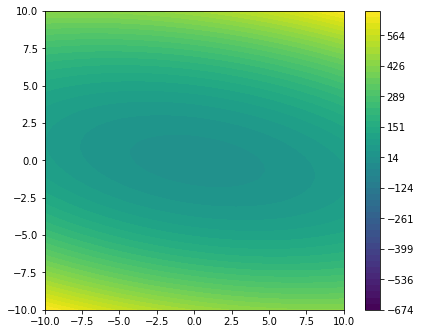

In [83]:
def plot_minimizier(f, xk=[]):
  x = np.linspace(-10, 10, 40, dtype=np.float32)
  y = np.linspace(-10, 10, 40, dtype=np.float32)
  X, Y = np.meshgrid(x, y)
  grid = np.vstack((X.flatten(),Y.flatten()))
  Z = f(torch.from_numpy(grid))
  Z = np.reshape(Z.detach().numpy(), (40,40))

  plt.gca().set_aspect("equal")
  plt.gcf().set_size_inches(7.5, 5.5)
  contourplot = plt.contourf(X, Y, Z, levels=np.linspace(-np.amax(Z),np.amax(Z),50))
  cbar = plt.colorbar(contourplot)
  plt.plot(xk, 'w.', linestyle='dashed')
  plt.show()

plot_minimizier(objective_function)

## Line Search methods

The core idea of Line Search method is to update the solution $x_k$ iteratively according to

$x_{k+1} = x_k + \alpha_k p_k,$

where $p_k$ is a descent direction and $\alpha_k$ a certain step size. Ideally, this will result in a decreasing sequence

$f(x_0) \geq f(x_1) \geq \dots \geq f(x_{k-1}) \geq f(x_k)$

which converges to a certain minimum. These approaches are also called line-search methods, as we are looking for the minimum across the line defined by the search direction $p_k$. It is evident that convergence will depend on the specific choice of the descent direction $p_k$ and step size $\alpha_k$.

### Gradient descent

The natural choice for $p_k$ is to take the direction of steepest descent $-\nabla f(x_k)$. Taking the appropriate step size is a more difficult problem to solve. This leaves the choice regarding the step size open. A popular strategy id backtracking line-search.

In [66]:
def backtrack(f, x0, p0, alpha, tau=0.5, c=0.5):
  f0 = f(x0)
  m = torch.norm(p0) ** 2
  t = - c * m
  while f0 - f(x0 + alpha * p0) <= alpha * t:
    alpha = tau*alpha
  return alpha


In other words, we are decreasing $\alpha$ iteratively by replacing it with $\tau \alpha$, until the condition ... is met.

In [69]:
def iterate(f, x0, alpham=1.0, tol=1e-3):
  x = x0
  f0 = f(x)
  diff = np.inf
  while diff > tol:
    f0.backward()
    p = x.grad
    alpha = backtrack(f, x, p, alpham)
    x = x + alpha * p
    f1 = f(x)
    diff = f0 - f1
    f0 = f1
  # compute the Wolfe condition
  return x

x0 = torch.rand(2,1, requires_grad=True)
f0 = objective_function(x0)
print(f0.backward())
iterate(objective_function, x0)
  

None


tensor([[0.8192],
        [0.6906]], grad_fn=<AddBackward0>)

## Analogy to linear systems

Coming from numerical linear algebra, I couldn't resist to introduce some linear algebra. A central problem of numerical linear algebra is the solution of linear systems of the form

$Ax = b.$

## References